In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
print(tf.__version__)

2.4.0


In [4]:
def discriminator_model():
  input_layer=keras.Input(shape=(720,1024,3))
  x=keras.layers.Conv2D(32,(11,11),strides=2)(input_layer)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Conv2D(64,(7,7),strides=2,kernel_regularizer=keras.regularizers.l2)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Conv2D(64,(5,5),kernel_regularizer=keras.regularizers.l2,strides=2)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Conv2D(128,(3,3),kernel_regularizer=keras.regularizers.l2,strides=2)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Conv2D(128,(3,3),kernel_regularizer=keras.regularizers.l2,strides=2)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Conv2D(128,(3,3),kernel_regularizer=keras.regularizers.l2,strides=2)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Conv2D(128,(3,3),kernel_regularizer=keras.regularizers.l2,strides=1)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Flatten()(x)
  x=keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2,)(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Dense(256,kernel_regularizer=keras.regularizers.l2,)(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=keras.regularizers.l2)(x)
  model=keras.Model(inputs=input_layer,outputs=x)
  return model

def generator_block(i,filters):
    input_layer=keras.Input(shape=i.shape[1:])
    o=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_regularizer=keras.regularizers.l2)(input_layer)
    o=keras.layers.BatchNormalization()(o)
    o=keras.layers.LeakyReLU()(o)
    o=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_regularizer=keras.regularizers.l2)(o)
    o=keras.layers.BatchNormalization()(o)
    o=keras.layers.add([input_layer,o])
    model_block=keras.Model(inputs=input_layer,outputs=o)
    return model_block

def generator_model():
  inputs=keras.Input(shape=(180,256,3))
  x=keras.layers.Conv2D(32,(5,5),padding='same')(inputs)
  x=keras.layers.LeakyReLU()(x)
  skip=x
  x=generator_block(x,32)(x)
  x=generator_block(x,32)(x)
  x=keras.layers.Conv2D(64,(5,5),padding='same')(x)
  x=keras.layers.LeakyReLU()(x)
  x=generator_block(x,64)(x)
  x=generator_block(x,64)(x)
  x=keras.layers.Conv2D(64,(5,5),padding='same')(x)
  x=keras.layers.LeakyReLU()(x)
  x=generator_block(x,64)(x)
  x=generator_block(x,64)(x)
  x=keras.layers.Conv2D(64,(5,5),padding='same')(x)
  x=keras.layers.LeakyReLU()(x)
  x=generator_block(x,64)(x)
  x=generator_block(x,64)(x)
  x=keras.layers.Conv2D(32,(3,3),padding='same')(x)
  x=keras.layers.LeakyReLU()(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.add([x,skip])
  x=keras.layers.Conv2DTranspose(32,(2,2),strides=4)(x)
  x=keras.layers.Conv2D(32,(3,3),padding='same')(x)
  x=keras.layers.LeakyReLU()(x)
  x=generator_block(x,32)(x)
  x=keras.layers.Conv2D(3,(3,3),padding='same',activation=keras.activations.sigmoid)(x)
  generator=keras.Model(inputs=inputs,outputs=x)
  return generator

In [6]:
class SRGAN(keras.Model):
  def __init__(self,discriminator,generator):
    super(SRGAN, self).__init__()
    self.discriminator=discriminator
    self.generator=generator
  def compile(self, loss_fn,discriminator_op,generator_op):
    super(SRGAN, self).compile()
    self.loss_fn=loss_fn
    self.discriminator_op=discriminator_op
    self.generator_op=generator_op
  def train_step(self,data):
    input_images=data[0]
    target_images=data[1]
    batch_size=1
    print(input_images.shape)
    for k in range(1):
      ind=np.random.randint(low=0,high=16,size=batch_size)
      batch_real=tf.gather(target_images,ind)
      batch_fake=self.generator(tf.gather(input_images,ind))
      y_batch_real=np.ones((batch_size,1),dtype=np.float32)
      y_batch_fake=np.zeros((batch_size,1),dtype=np.float32)
      xtrain=tf.concat([batch_real,batch_fake],axis=0)
      ytrain=tf.concat([y_batch_real,y_batch_fake],axis=0)
      with tf.GradientTape() as tape:
        predictions=self.discriminator(xtrain)
        d_loss=self.loss_fn(ytrain,predictions)
      
      grads=tape.gradient(d_loss,self.discriminator.trainable_weights)
      self.discriminator_op.apply_gradients(
          zip(grads,self.discriminator.trainable_weights)
      )
    for k in range(5):
      misleading_labels=np.ones((batch_size,1),dtype=np.float32)
      ind=np.random.randint(low=0,high=16,size=batch_size)
      batch_fake=tf.gather(input_images,ind)
      target_sample=tf.gather(target_images,ind)
      with tf.GradientTape() as tape:
        generated_image=self.generator(batch_fake)
        vgg_1_real=vgg_model_1(target_sample)
        vgg_1_fake=vgg_model_1(generated_image)
        vgg_2_real=vgg_model_2(target_sample)
        vgg_2_fake=vgg_model_2(generated_image)
        predictions=self.discriminator(generated_image)
        g_loss=0.001*self.loss_fn(misleading_labels,predictions) 
        g_loss+=0.5*tf.keras.losses.MeanSquaredError()(vgg_2_real,vgg_2_fake)
        g_loss+=tf.keras.losses.MeanSquaredError()(vgg_1_real,vgg_1_fake)
        g_loss+=tf.keras.losses.MeanSquaredError()(self.generator(batch_fake),target_sample)
      grads=tape.gradient(g_loss,self.generator.trainable_weights)
      self.generator_op.apply_gradients(
          zip(grads,self.generator.trainable_weights)
      )

    return {'d_loss':d_loss,'g_loss':g_loss}


  def get_config(self):
    config = super(Linear, self).get_config()
    config.update({"units": self.units})
    return config

dis=discriminator_model()
gen=generator_model()

gan=SRGAN(dis,gen)
gan.compile(
    discriminator_op=keras.optimizers.Adam(learning_rate=0.0003),
    generator_op=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy()
)

In [36]:
dis.load_weights('/content/drive/MyDrive/SRGAN/dis_weight_final.h5')
gen.load_weights('/content/drive/MyDrive/SRGAN/gen_weight_final.h5')

In [132]:
def showImages(path_to_img,offset=0,crop=True):
  img=Image.open(path_to_img)
  i=offset
  if crop:
    img = np.asarray( img, dtype="int32" )[i:180+i,i:256+i,:]
  else:
    img = np.asarray( img, dtype="int32" )[:360:2,:512:2,:]
  # img = np.asarray( img, dtype="int32" )[i:180+i,i:256+i,:]

  gen_img=gen.predict(img.reshape(1,180,256,3)/255.)
  fig,ax=plt.subplots(1,2,figsize=(40, 20),gridspec_kw={'wspace': 0.03})
  ax[0].imshow(img)
  ax[0].axis('off')
  ax[1].imshow(gen_img[0])
  ax[1].axis('off')

In [74]:
img_names=[i for i in os.listdir('/content/drive/MyDrive/SRGAN/train_target')]
target_paths=['/content/drive/MyDrive/SRGAN/train_target/'+i for i in img_names]

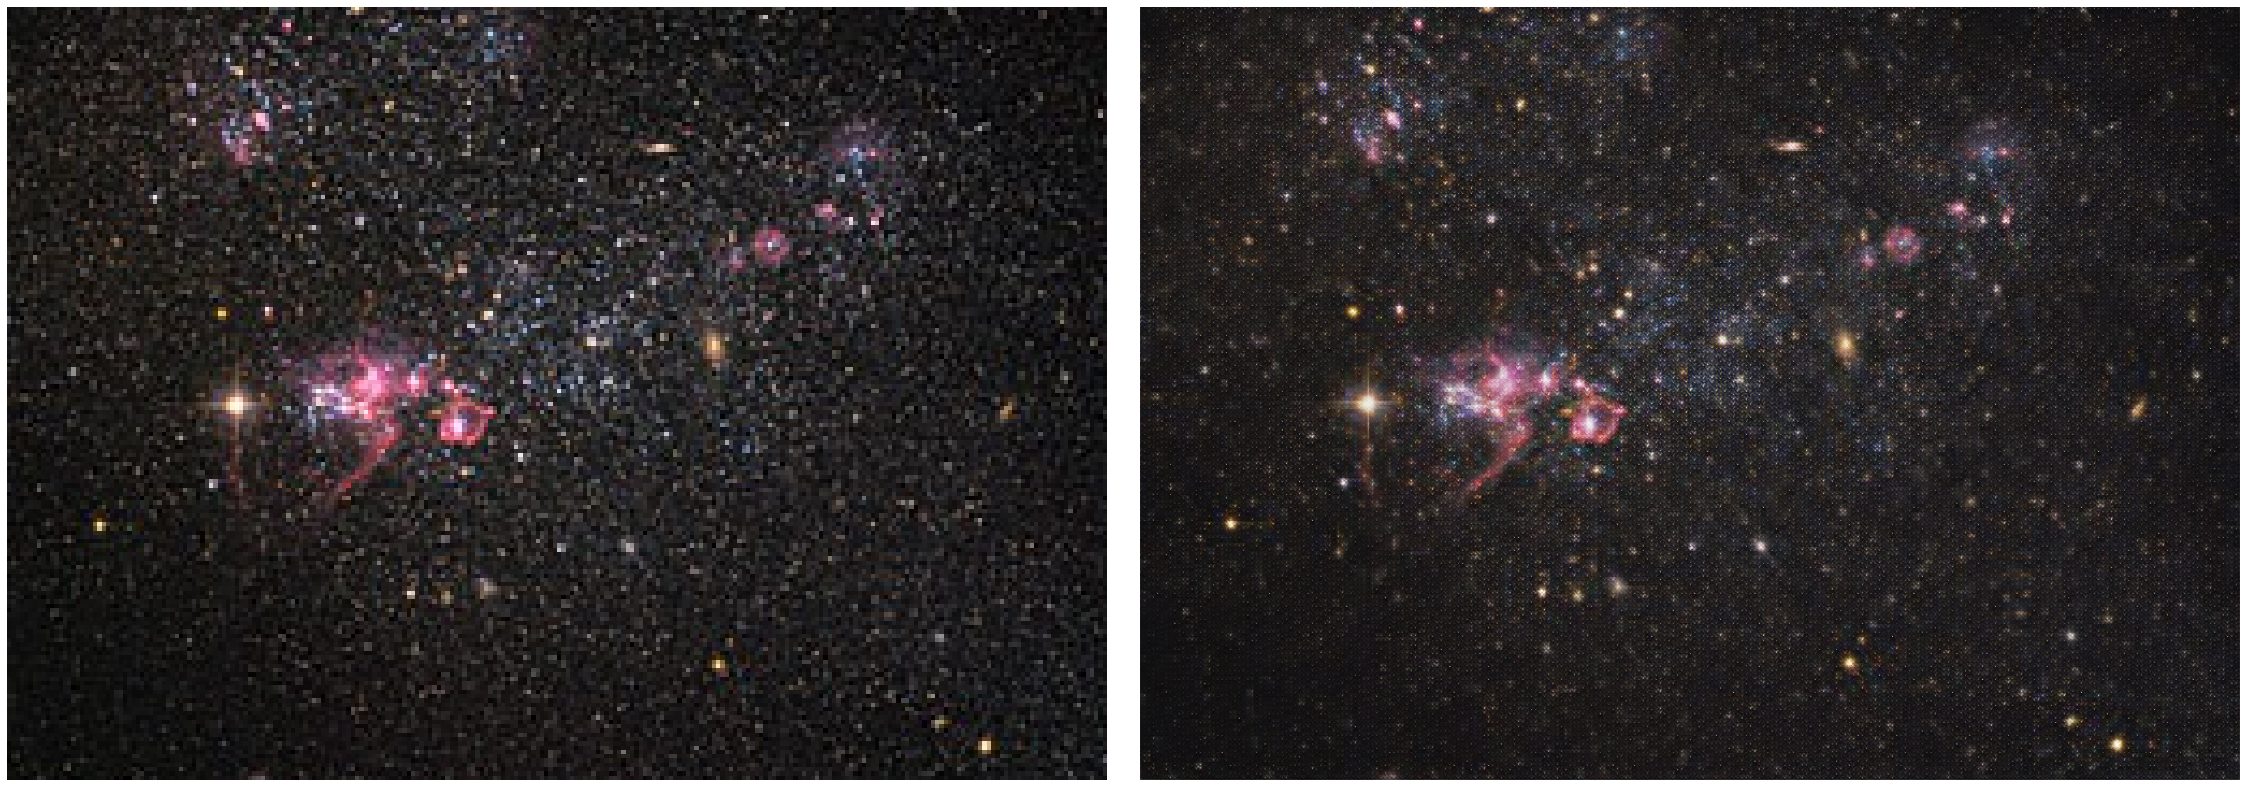

In [137]:
showImages(target_paths[253],0)

In [93]:
# 54, '/content/drive/MyDrive/SRGAN/aaaaa.jpg' , 76[50:] , 97[50:] , 654 , 578 ,392[0:] ,322[0:] , 473[50:]